In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')
import json

### Error Analysis Validation

This notebook validates the error analysis tool using:
- Leave-One-Out Cross-Validation (LOOCV) for small samples
- Efron's .632+ Bootstrap for confidence intervals
- Stability selection for robust feature importance (limited data)
- Influence analysis to identify outlier equations

Input: Feature-error relationships from previous notebook

Output: Validated findings with confidence intervals and robustness metrics

### Validation methods

#### Leave-One-Out Cross-Validation
- used for small samples: each sample is used once as test set while all others form training set

####  Efron's .632+ Bootstrap for confidence intervals
- provides better bias-variance tradeoff than standard bootstrap
- combines training error and out-of-bag error optimally

#### Stability selection
- runs feature selection many times on random subsamples
- features selected consistently have stronger effect on outcomes

#### Influence analysis 
- in order to identify outlier equations
- measures how much each equation affects model performance
- high influence indicates potential outliers or critical cases

In [ ]:
class ValidationMethods:
    def __init__(self, features_df: pd.DataFrame, error_df: pd.DataFrame):
        self.features_df = features_df
        self.error_df = error_df
        self.scaler = StandardScaler()

    def loocv(self, model_class=RandomForestClassifier, **model_params) -> Dict:

        X = self.features_df.select_dtypes(include=[np.number]).fillna(0).values
        X_scaled = self.scaler.fit_transform(X)
        loo = LeaveOneOut()
        results_by_error = {}

        for error_col in self.error_df.columns:
            y = self.error_df[error_col].astype(int).values
            if y.sum() < 2:
                continue

            predictions = []
            probabilities = []
            true_labels = []
            equation_indices = []

            for train_idx, test_idx in loo.split(X_scaled):
                X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                model = model_class(**model_params)
                model.fit(X_train, y_train)

                pred = model.predict(X_test)[0]
                if hasattr(model, 'predict_proba') and len(np.unique(y_train)) > 1:
                    prob = model.predict_proba(X_test)[0, 1]
                else:
                    prob = float(pred)

                predictions.append(pred)
                probabilities.append(prob)
                true_labels.append(y_test[0])
                equation_indices.append(test_idx[0])

            accuracy = accuracy_score(true_labels, predictions)
            if len(np.unique(true_labels)) > 1:
                auc = roc_auc_score(true_labels, probabilities)
            else:
                auc = np.nan

            results_by_error[error_col] = {
                'accuracy': accuracy,
                'auc': auc,
                'predictions': predictions,
                'probabilities': probabilities,
                'true_labels': true_labels,
                'equation_indices': equation_indices,
                'n_errors': sum(true_labels),
                'n_correct': sum(1 for p, t in zip(predictions, true_labels) if p == t)
            }

            if not np.isnan(auc):
                print(f"  {error_col}: Accuracy={accuracy:.3f}, AUC={auc:.3f}")
            else:
                print(f"  {error_col}: Accuracy={accuracy:.3f}, AUC=N/A")

        return results_by_error

    def efron_632_bootstrap(self, model_class=RandomForestClassifier,
                            n_bootstrap: int = 200, **model_params) -> Dict:
        X = self.features_df.select_dtypes(include=[np.number]).fillna(0).values
        X_scaled = self.scaler.fit_transform(X)
        n_samples = len(X_scaled)
        results_by_error = {}

        for error_col in self.error_df.columns:
            y = self.error_df[error_col].astype(int).values
            if y.sum() < 2:
                continue

            bootstrap_scores = []
            oob_scores = []
            train_scores = []

            for b in range(n_bootstrap):
                boot_idx = np.random.choice(n_samples, n_samples, replace=True)
                oob_idx = np.setdiff1d(np.arange(n_samples), boot_idx)
                if len(oob_idx) == 0:
                    continue

                X_boot = X_scaled[boot_idx]
                y_boot = y[boot_idx]
                X_oob = X_scaled[oob_idx]
                y_oob = y[oob_idx]

                model = model_class(**model_params)
                model.fit(X_boot, y_boot)

                train_pred = model.predict(X_boot)
                train_acc = accuracy_score(y_boot, train_pred)
                train_scores.append(train_acc)

                oob_pred = model.predict(X_oob)
                oob_acc = accuracy_score(y_oob, oob_pred)
                oob_scores.append(oob_acc)

                p_positive = y.mean()
                no_info_err = p_positive * (1 - p_positive) + (1 - p_positive) * p_positive

                if train_acc != no_info_err:
                    r = (train_acc - oob_acc) / (train_acc - no_info_err)
                    r = max(0, min(r, 1))
                else:
                    r = 0

                w = 0.632 / (1 - 0.368 * r)
                err_632plus = (1 - w) * train_acc + w * oob_acc
                bootstrap_scores.append(err_632plus)

            if bootstrap_scores:
                mean_score = np.mean(bootstrap_scores)
                ci_lower = np.percentile(bootstrap_scores, 2.5)
                ci_upper = np.percentile(bootstrap_scores, 97.5)

                results_by_error[error_col] = {
                    'mean_score': mean_score,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'std': np.std(bootstrap_scores),
                    'bootstrap_scores': bootstrap_scores,
                    'oob_mean': np.mean(oob_scores) if oob_scores else np.nan,
                    'train_mean': np.mean(train_scores) if train_scores else np.nan
                }

                print(f"  {error_col}: Score={mean_score:.3f} CI=[{ci_lower:.3f}, {ci_upper:.3f}]")

        return results_by_error

    def stability_selection(self, n_bootstrap: int = 100,
                           sample_fraction: float = 0.5,
                           threshold: float = 0.8) -> Dict:
        X = self.features_df.select_dtypes(include=[np.number]).fillna(0)
        feature_names = X.columns.tolist()
        X_scaled = self.scaler.fit_transform(X.values)
        n_samples = len(X_scaled)
        n_features = X_scaled.shape[1]
        results_by_error = {}

        for error_col in self.error_df.columns:
            y = self.error_df[error_col].astype(int).values
            if y.sum() < 2:
                continue

            selection_counts = np.zeros(n_features)

            for b in range(n_bootstrap):
                subsample_size = int(n_samples * sample_fraction)
                if subsample_size < 2:
                    continue
                idx = np.random.choice(n_samples, subsample_size, replace=False)
                X_sub = X_scaled[idx]
                y_sub = y[idx]
                if len(np.unique(y_sub)) < 2:
                    continue

                model = LogisticRegression(
                    penalty='l1',
                    solver='liblinear',
                    C=0.1,
                    random_state=b
                )
                try:
                    model.fit(X_sub, y_sub)
                    selected = np.abs(model.coef_[0]) > 1e-5
                    selection_counts += selected
                except Exception:
                    continue

            selection_probs = selection_counts / n_bootstrap
            stable_features = []
            stable_indices = []
            for i, (prob, name) in enumerate(zip(selection_probs, feature_names)):
                if prob >= threshold:
                    stable_features.append(name)
                    stable_indices.append(i)

            results_by_error[error_col] = {
                'stable_features': stable_features,
                'stable_indices': stable_indices,
                'selection_probabilities': dict(zip(feature_names, selection_probs)),
                'n_stable': len(stable_features),
                'top_features': sorted(
                    zip(feature_names, selection_probs),
                    key=lambda x: x[1],
                    reverse=True
                )[:10]
            }

            print(f"  {error_col}: {len(stable_features)} stable features found")
            if stable_features:
                print(f"    Top 3: {', '.join(stable_features[:3])}")

        return results_by_error

    def influence_analysis(self, model_class=RandomForestClassifier, **model_params) -> Dict:
        X = self.features_df.select_dtypes(include=[np.number]).fillna(0).values
        X_scaled = self.scaler.fit_transform(X)
        n_samples = len(X_scaled)

        if 'model' in self.features_df.columns:
            equation_ids = self.features_df['model'].tolist()
        else:
            equation_ids = self.features_df.index.tolist()

        results_by_error = {}

        for error_col in self.error_df.columns:
            y = self.error_df[error_col].astype(int).values
            if y.sum() < 2:
                continue

            model_full = model_class(**model_params)
            model_full.fit(X_scaled, y)
            y_pred_full = model_full.predict(X_scaled)
            baseline_accuracy = accuracy_score(y, y_pred_full)
            influence_scores = []

            for i in range(n_samples):
                mask = np.ones(n_samples, dtype=bool)
                mask[i] = False
                X_without_i = X_scaled[mask]
                y_without_i = y[mask]

                model_without_i = model_class(**model_params)
                model_without_i.fit(X_without_i, y_without_i)
                y_pred_without_i = model_without_i.predict(X_scaled)
                accuracy_without_i = accuracy_score(y, y_pred_without_i)
                influence = baseline_accuracy - accuracy_without_i
                pred_change = y_pred_full[i] != model_without_i.predict(X_scaled[i:i+1])[0]

                influence_scores.append({
                    'equation_id': equation_ids[i],
                    'index': i,
                    'influence': influence,
                    'prediction_changed': pred_change,
                    'true_label': y[i],
                    'baseline_prediction': y_pred_full[i]
                })

            influence_scores.sort(key=lambda x: abs(x['influence']), reverse=True)
            influences = [s['influence'] for s in influence_scores]
            influence_threshold = (
                np.mean(np.abs(influences)) + 2 * np.std(np.abs(influences))
            )
            outliers = [
                s for s in influence_scores
                if abs(s['influence']) > influence_threshold
            ]

            results_by_error[error_col] = {
                'baseline_accuracy': baseline_accuracy,
                'influence_scores': influence_scores,
                'outliers': outliers,
                'n_outliers': len(outliers),
                'mean_influence': np.mean(np.abs(influences)),
                'max_influence': max(np.abs(influences)) if influences else 0
            }

            print(f"  {error_col}: {len(outliers)} influential equations (outliers) found")
            if outliers:
                print(
                    f"    Most influential: {outliers[0]['equation_id']} "
                    f"(influence={outliers[0]['influence']:.3f})"
                )

        return results_by_error

    def visualize_validation_results(
        self, 
        loocv_results: Dict, 
        bootstrap_results: Dict,
        stability_results: Dict, 
        influence_results: Dict
    ):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Validation Analysis Results', fontsize=16)
        
        # 1. LOOCV Performance
        ax1 = axes[0, 0]
        if loocv_results:
            error_types = list(loocv_results.keys())
            accuracies = [loocv_results[e]['accuracy'] for e in error_types]
            
            ax1.bar(
                range(len(error_types)), 
                accuracies, 
                color='skyblue', 
                edgecolor='black'
            )
            ax1.set_xticks(range(len(error_types)))
            ax1.set_xticklabels(error_types, rotation=45, ha='right')
            ax1.set_ylabel('LOOCV Accuracy')
            ax1.set_title('Leave-One-Out Cross-Validation Results')
            ax1.set_ylim(0, 1)
            
            for i, acc in enumerate(accuracies):
                ax1.text(i, acc + 0.02, f'{acc:.3f}', ha='center')
        
        # 2. Bootstrap Confidence Intervals
        ax2 = axes[0, 1]
        if bootstrap_results:
            error_types = list(bootstrap_results.keys())
            means = [bootstrap_results[e]['mean_score'] for e in error_types]
            ci_lower = [bootstrap_results[e]['ci_lower'] for e in error_types]
            ci_upper = [bootstrap_results[e]['ci_upper'] for e in error_types]
            
            x = range(len(error_types))
            ax2.scatter(x, means, color='red', s=100, zorder=3)
            
            for i, (m, l, u) in enumerate(zip(means, ci_lower, ci_upper)):
                ax2.plot([i, i], [l, u], 'k-', linewidth=2)
                ax2.plot([i-0.1, i+0.1], [l, l], 'k-', linewidth=2)
                ax2.plot([i-0.1, i+0.1], [u, u], 'k-', linewidth=2)
            
            ax2.set_xticks(x)
            ax2.set_xticklabels(error_types, rotation=45, ha='right')
            ax2.set_ylabel('Accuracy Score')
            ax2.set_title("Efron's .632+ Bootstrap Confidence Intervals")
            ax2.set_ylim(0, 1)
        
        # 3. Stability Selection
        ax3 = axes[1, 0]
        if stability_results:
            all_features = {}
            for error_type, results in stability_results.items():
                for feat, prob in results['selection_probabilities'].items():
                    if feat not in all_features:
                        all_features[feat] = []
                    all_features[feat].append(prob)
            
            avg_probs = {
                feat: np.mean(probs) 
                for feat, probs in all_features.items()
            }
            top_features = sorted(
                avg_probs.items(), 
                key=lambda x: x[1], 
                reverse=True
            )[:15]
            
            features, probs = zip(*top_features)
            y_pos = range(len(features))
            
            ax3.barh(y_pos, probs, color='lightgreen', edgecolor='black')
            ax3.set_yticks(y_pos)
            ax3.set_yticklabels(features)
            ax3.set_xlabel('Average Selection Probability')
            ax3.set_title('Top 15 Features by Stability Selection')
            ax3.axvline(0.8, color='red', linestyle='--', label='Stability threshold')
            ax3.legend()
        
        # 4. Influence Analysis
        ax4 = axes[1, 1]
        if influence_results:
            all_influences = []
            all_labels = []
            
            for error_type, results in influence_results.items():
                for score in results['influence_scores'][:20]:
                    all_influences.append(abs(score['influence']))
                    all_labels.append(f"{score['equation_id']} ({error_type[:10]}...)")
            
            sorted_idx = np.argsort(all_influences)[-10:]
            top_influences = [all_influences[i] for i in sorted_idx]
            top_labels = [all_labels[i] for i in sorted_idx]
            
            y_pos = range(len(top_influences))
            ax4.barh(y_pos, top_influences, color='salmon', edgecolor='black')
            ax4.set_yticks(y_pos)
            ax4.set_yticklabels(top_labels, fontsize=8)
            ax4.set_xlabel('Absolute Influence Score')
            ax4.set_title('Top 10 Most Influential Equations')
        
        plt.tight_layout()
        return fig

    def generate_validation_report(
            self, 
            loocv_results: dict, 
            bootstrap_results: dict,
            stability_results: dict, 
            influence_results: dict
    ) -> str:
        report = []
        report.append("="*80)
        report.append("VALIDATION ANALYSIS REPORT")
        report.append("="*80)
        
        report.append("\n1. LEAVE-ONE-OUT CROSS-VALIDATION")
        report.append("-"*40)
        if loocv_results:
            try:
                avg_accuracy = np.mean([r.get('accuracy', 0.0) for r in loocv_results.values()])
                report.append(f"Average accuracy across error types: {avg_accuracy:.3f}")
                report.append("\nPer error type:")
                for error_type, results in loocv_results.items():
                    n_correct = results.get('n_correct', 0)
                    n_total = len(results.get('predictions', []))
                    accuracy = results.get('accuracy', 0.0)
                    report.append(
                        f"  {error_type}: {accuracy:.3f} "
                        f"({n_correct}/{n_total} correct)"
                    )
            except Exception as e:
                report.append(f"Error in LOOCV summary: {e}")
        else:
            report.append("No LOOCV results available.")
        
        report.append("\n\n2. EFRON'S .632+ BOOTSTRAP")
        report.append("-"*40)
        if bootstrap_results:
            try:
                report.append("95% Confidence Intervals:")
                for error_type, results in bootstrap_results.items():
                    mean_score = results.get('mean_score', 0.0)
                    ci_lower = results.get('ci_lower', 0.0)
                    ci_upper = results.get('ci_upper', 0.0)
                    report.append(
                        f"  {error_type}: {mean_score:.3f} "
                        f"[{ci_lower:.3f}, {ci_upper:.3f}]"
                    )
            except Exception as e:
                report.append(f"Error in bootstrap summary: {e}")
        else:
            report.append("No bootstrap results available.")
        
        report.append("\n\n3. STABILITY SELECTION")
        report.append("-"*40)
        if stability_results:
            try:
                all_stable = set()
                for error_type, results in stability_results.items():
                    stable_features = results.get('stable_features', [])
                    n_stable = results.get('n_stable', len(stable_features))
                    all_stable.update(stable_features)
                    report.append(f"\n{error_type}: {n_stable} stable features")
                    if stable_features:
                        report.append(f"  Top 3: {', '.join(stable_features[:3])}")
                report.append(f"\nTotal unique stable features: {len(all_stable)}")
            except Exception as e:
                report.append(f"Error in stability selection summary: {e}")
        else:
            report.append("No stability selection results available.")
        
        report.append("\n\n4. INFLUENCE ANALYSIS")
        report.append("-"*40)
        if influence_results:
            try:
                total_outliers = sum(r.get('n_outliers', 0) for r in influence_results.values())
                report.append(f"Total influential equations (outliers): {total_outliers}")
                for error_type, results in influence_results.items():
                    n_outliers = results.get('n_outliers', 0)
                    outliers = results.get('outliers', [])
                    if outliers:
                        most_influential = outliers[0]
                        eq_id = most_influential.get('equation_id', 'N/A')
                        influence_score = most_influential.get('influence', 0.0)
                        report.append(f"\n{error_type}: {n_outliers} outliers")
                        report.append(f"  Most influential: {eq_id}")
                        report.append(f"  Influence score: {influence_score:.3f}")
            except Exception as e:
                report.append(f"Error in influence analysis summary: {e}")
        else:
            report.append("No influence analysis results available.")
        
        report.append("\n" + "="*80)
        return "\n".join(report)

#### Loading the data 
check for file paths

In [70]:
# file paths
VERSION = '001'  # Change to match your version

# Load the three required files
features_df = pd.read_csv(f'./features_analysis_{VERSION}.csv')
print(f"Loaded features: {features_df.shape}")

with open(f'./comparison_results_{VERSION}.json', 'r') as f:
    comparison_results = json.load(f)
print(f"Loaded comparison results: {len(comparison_results)} models")

with open(f'./categorization_results_{VERSION}.json', 'r') as f:
    categorization_results = json.load(f)
print(f"Loaded categorization results: {len(categorization_results)} models")

Loaded features: (10, 77)
Loaded comparison results: 8 models
Loaded categorization results: 7 models


#### Data preparation

In [71]:
# data preparation
def prep_data(
        features_df: pd.DataFrame,
        comparison_results: List[Dict],
        categorization_results: List[Dict]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
   
    # Error categories
    error_categories = [
        'symbol_recognition',
        'subscript_superscript', 
        'structural_corruption',
        'derivative_notation',
        'boundary_initial_conditions',
        'operator_errors',
        'completeness_errors',
        'formatting_errors'
    ]
    
    # Initialize error dataframe
    error_data = []
    
    for cat_result in categorization_results:
        model = cat_result.get('model')
        error_dist = cat_result.get('error_distribution', {}).get('by_category', {})
        
        # Create binary indicators for each error type
        error_row = {'model': model}
        for error_cat in error_categories:
            # Binary: 1 if this error type occurred, 0 otherwise
            error_row[f'has_{error_cat}'] = int(error_dist.get(error_cat, 0) > 0)
        
        # Add severity indicators
        severity_dist = cat_result.get('error_distribution', {}).get('by_severity', {})
        error_row['has_critical_errors'] = int(severity_dist.get('critical', 0) > 0)
        error_row['has_high_errors'] = int(severity_dist.get('high', 0) > 0)
        
        # Add overall error indicator
        error_row['has_any_error'] = int(cat_result.get('total_errors', 0) > 0)
        
        error_data.append(error_row)
    
    error_df = pd.DataFrame(error_data)
    
    # Align features_df with error_df by model
    features_df = features_df.copy()
    if 'model' in features_df.columns:
        # Merge to ensure alignment
        merged_df = features_df.merge(error_df, on='model', how='inner')
        
        # Split back into features and errors
        feature_cols = [col for col in features_df.columns if col != 'model']
        error_cols = [col for col in error_df.columns if col != 'model']
        
        # Keep 'model' in both dataframes
        aligned_features = merged_df[['model'] + feature_cols]
        aligned_errors = merged_df[['model'] + error_cols]
        
        # Set model as index for easier reference
        aligned_features = aligned_features.set_index('model')
        aligned_errors = aligned_errors.set_index('model')

        # Print summary of what was done
        print("\n" + "="*60)
        print("DATA PREPARATION SUMMARY")
        print("="*60)
        print(f"✓ Processed {len(categorization_results)} models from error analysis")
        print(f"✓ Created {len(error_categories)} binary error indicators:")
        for cat in error_categories:
            count = aligned_errors[f'has_{cat}'].sum()
            print(f"  - has_{cat}: {count} models affected")
        print(f"\n✓ Added severity indicators:")
        print(f"  - has_critical_errors: {aligned_errors['has_critical_errors'].sum()} models")
        print(f"  - has_high_errors: {aligned_errors['has_high_errors'].sum()} models")
        print(f"  - has_any_error: {aligned_errors['has_any_error'].sum()} models")
        print(f"\n✓ Final dataset: {len(aligned_features)} models with {len(feature_cols)} features")
        print(f"✓ Error matrix: {aligned_errors.shape[0]} models × {aligned_errors.shape[1]} error types")
        print("="*60 + "\n")
        
        return aligned_features, aligned_errors
    else:
        # If no model column, assume same order
        print("Warning: No 'model' column found. Assuming data is in same order.")
        return features_df, error_df.drop('model', axis=1)

In [72]:
#should match
print(f"\nUnique models in features: {features_df['model'].nunique()}")
print(f"\nTotal categorization results: {len(categorization_results)}")

# in case of missing model, filtering helps
models_with_results = [cat['model'] for cat in categorization_results]
print(f"Models with categorization results: {models_with_results}")

features_df_filtered = features_df[features_df['model'].isin(models_with_results)].copy()


Unique models in features: 10

Total categorization results: 7
Models with categorization results: ['BIOMD0000000960', 'BIOMD0000000958', 'BIOMD0000000956', 'BIOMD0000000962', '2024_dec_epi_1_model_B', 'BIOMD0000000957', 'SAPHIRE']


In [73]:
# run prep
aligned_features, error_df = prep_data(
    features_df_filtered,
    comparison_results,
    categorization_results
)


DATA PREPARATION SUMMARY
✓ Processed 7 models from error analysis
✓ Created 8 binary error indicators:
  - has_symbol_recognition: 4 models affected
  - has_subscript_superscript: 2 models affected
  - has_structural_corruption: 0 models affected
  - has_derivative_notation: 0 models affected
  - has_boundary_initial_conditions: 1 models affected
  - has_operator_errors: 2 models affected
  - has_completeness_errors: 3 models affected
  - has_formatting_errors: 0 models affected

✓ Added severity indicators:
  - has_critical_errors: 1 models
  - has_high_errors: 6 models
  - has_any_error: 6 models

✓ Final dataset: 7 models with 76 features
✓ Error matrix: 7 models × 11 error types



In [74]:
#initialization of validator
validator = ValidationMethods(aligned_features, error_df)

#### Running the methods

In [75]:
# 1. LOOCV
print("\n1. LOOCV")
loocv_results = validator.loocv(
    model_class=RandomForestClassifier,
    n_estimators=100,
    random_state=42
)

# 2. Efron's .632+ Bootstrap
print("\n2. EFRON'S .632+ BOOTSTRAP")
bootstrap_results = validator.efron_632_bootstrap(
    model_class=RandomForestClassifier,
    n_bootstrap=200,
    n_estimators=100,
    random_state=42
)

# 3. Stability Selection
print("\n3. STABILITY SELECTION")
stability_results = validator.stability_selection(
    n_bootstrap=100,
    sample_fraction=0.5,
    threshold=0.8
)

# 4. Influence Analysis
print("\n4. INFLUENCE ANALYSIS")
influence_results = validator.influence_analysis(
    model_class=RandomForestClassifier,
    n_estimators=100,
    random_state=42
)


1. LOOCV
Running Leave-One-Out Cross-Validation...
  has_symbol_recognition: Accuracy=0.429, AUC=0.667
  has_subscript_superscript: Accuracy=0.571, AUC=0.600
  has_operator_errors: Accuracy=0.571, AUC=0.700
  has_completeness_errors: Accuracy=0.714, AUC=0.750
  has_high_errors: Accuracy=0.714, AUC=0.000
  has_any_error: Accuracy=0.714, AUC=0.000

2. EFRON'S .632+ BOOTSTRAP

Running Efron's .632+ Bootstrap (200 iterations)...
  has_symbol_recognition: Score=0.511 CI=[0.000, 1.000]
  has_subscript_superscript: Score=0.608 CI=[0.000, 1.000]
  has_operator_errors: Score=0.670 CI=[0.000, 1.000]
  has_completeness_errors: Score=0.634 CI=[0.000, 1.000]
  has_high_errors: Score=0.831 CI=[0.000, 1.000]
  has_any_error: Score=0.829 CI=[0.376, 1.000]

3. STABILITY SELECTION

Running Stability Selection (threshold=0.8)...
  has_symbol_recognition: 0 stable features found
  has_subscript_superscript: 0 stable features found
  has_operator_errors: 0 stable features found
  has_completeness_errors: 

#### Validation results


GENERATING VISUALIZATIONS
Saved visualization to: validation_analysis_results.png


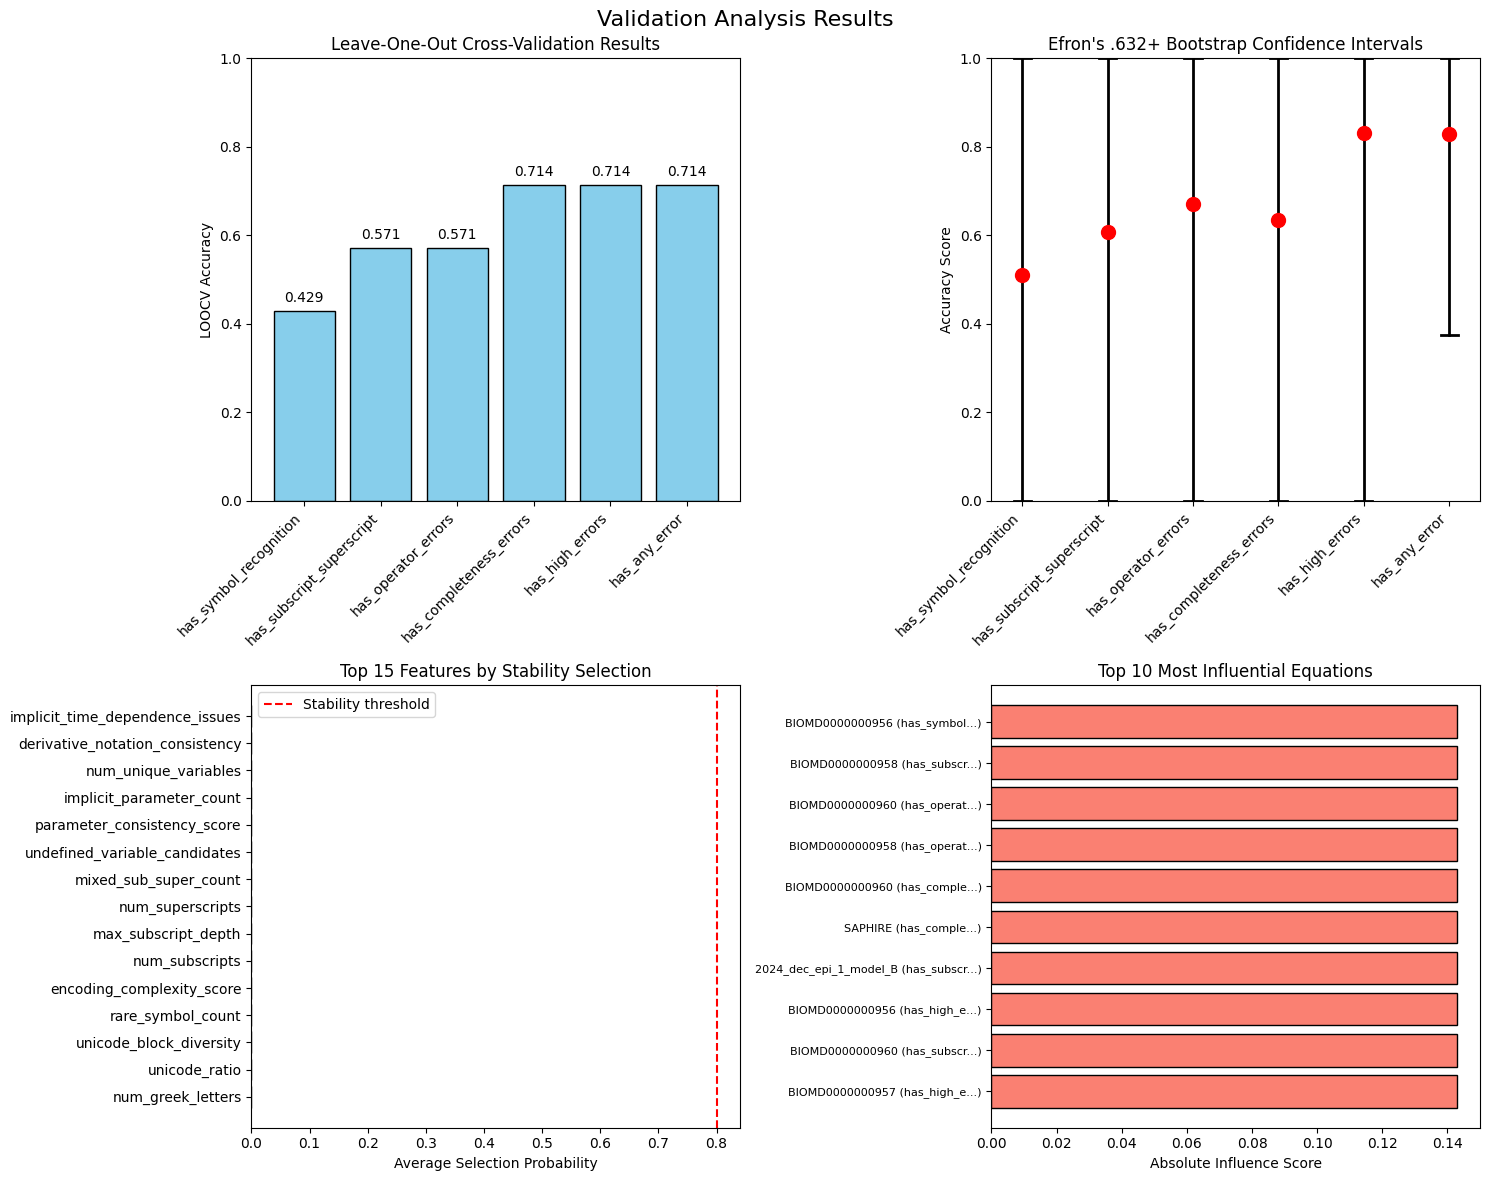

In [76]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Create visualization
fig = validator.visualize_validation_results(
    loocv_results,
    bootstrap_results,
    stability_results,
    influence_results
)

# Save figure
plt.savefig('validation_analysis_results.png', dpi=150, bbox_inches='tight')
print("Saved visualization to: validation_analysis_results.png")
plt.show()

In [77]:
# report

print("\n" + "="*60)
print("VALIDATION REPORT")
print("="*60)

# Generate text report
report = validator.generate_validation_report(
    loocv_results,
    bootstrap_results,
    stability_results,
    influence_results
)

print (report)

with open('validation_report.txt', 'w') as f:
    f.write(report)
print("\nSaved report to: validation_report.txt")


VALIDATION REPORT
VALIDATION ANALYSIS REPORT

1. LEAVE-ONE-OUT CROSS-VALIDATION
----------------------------------------
Average accuracy across error types: 0.619

Per error type:
  has_symbol_recognition: 0.429 (3/7 correct)
  has_subscript_superscript: 0.571 (4/7 correct)
  has_operator_errors: 0.571 (4/7 correct)
  has_completeness_errors: 0.714 (5/7 correct)
  has_high_errors: 0.714 (5/7 correct)
  has_any_error: 0.714 (5/7 correct)


2. EFRON'S .632+ BOOTSTRAP
----------------------------------------
95% Confidence Intervals:
  has_symbol_recognition: 0.511 [0.000, 1.000]
  has_subscript_superscript: 0.608 [0.000, 1.000]
  has_operator_errors: 0.670 [0.000, 1.000]
  has_completeness_errors: 0.634 [0.000, 1.000]
  has_high_errors: 0.831 [0.000, 1.000]
  has_any_error: 0.829 [0.376, 1.000]


3. STABILITY SELECTION
----------------------------------------

has_symbol_recognition: 0 stable features

has_subscript_superscript: 0 stable features

has_operator_errors: 0 stable features

In [78]:
all_results = {
    'loocv': loocv_results,
    'bootstrap': bootstrap_results,
    'stability': stability_results,
    'influence': influence_results,
    'summary': {
        'n_models': len(aligned_features),
        'n_features': len(aligned_features.columns),
        'n_error_types': len(error_df.columns),
        'avg_loocv_accuracy': np.mean([r['accuracy'] for r in loocv_results.values()])
    }
}

with open('validation_results.json', 'w') as f:
    json.dump(all_results, f, indent=2, default=str)
print("\nSaved complete results to: validation_results.json")


Saved complete results to: validation_results.json


In [79]:
# summary

avg_accuracy = np.mean([r['accuracy'] for r in loocv_results.values()])
print(f"\nOverall reliability: {avg_accuracy:.1%}")

if avg_accuracy > 0.8:
    print("✓ The error analysis tool is HIGHLY RELIABLE")
elif avg_accuracy > 0.6:
    print("⚠ The error analysis tool shows MODERATE reliability")
else:
    print("✗ The error analysis tool needs IMPROVEMENT")

# Most reliable error detections
reliable_errors = [(e, r['accuracy']) for e, r in loocv_results.items() if r['accuracy'] > 0.8]
if reliable_errors:
    print("\nMost reliably detected errors:")
    for error, acc in sorted(reliable_errors, key=lambda x: x[1], reverse=True)[:3]:
        print(f"  - {error}: {acc:.1%} accuracy")

# Total influential equations
total_outliers = sum(r['n_outliers'] for r in influence_results.values())
print(f"\nInfluential equations found: {total_outliers}")

print("\n" + "="*60)
print("Validation complete.")
print("="*60)


Overall reliability: 61.9%
⚠ The error analysis tool shows MODERATE reliability

Influential equations found: 0

Validation complete.
